# Environment

## Imports

In [156]:
:dep polars = { version = "0.46", features = [ "lazy", "cum_agg", "list_arithmetic", "round_series" ] }
:dep nalgebra
:dep argmin
:dep argmin-math = { version = "0.4", features = ["nalgebra_latest", "vec"] }
:dep itertools
:dep plotters = { version = "0.3", features = ["evcxr", "all_series"] }
:dep image
:dep base64

[Polars](https://pola.rs/) is a new DataFrame library meant to replace pandas, which is written in Rust. It has both a Python and a Rust interface

It's by far the largest library here, so it will take some time to compile. I have only enabled the features that I will use.

In [ ]:
use polars::prelude::*;
use plotters::prelude::*;

Error: the name `image` is defined multiple times

## Plot Output

The standard plot output for the `plotters` library becomes HTML, even though it's just an SVG. I introduce a wrapper here so that it forces it to label itself SVG, which LaTeX can render.

In [175]:
use image::{ImageBuffer, Rgb};

In [176]:
use base64::prelude::*;
use plotters::coord::Shift;
use std::io::Cursor;

pub struct PlotWrapper(String);

impl PlotWrapper {
    pub fn evcxr_display(&self) {
        println!("{}", self.0);
    }
}

pub fn my_evcxr_figure<
    Draw: FnOnce(DrawingArea<BitMapBackend, Shift>) -> Result<(), Box<dyn std::error::Error>>,
>(
    size: (u32, u32),
    draw: Draw,
) -> PlotWrapper {
    let mut rgb_data = vec![0u8; (size.0 * size.1 * 3) as usize];
    let root = BitMapBackend::with_buffer(&mut rgb_data, size).into_drawing_area();
    draw(root).expect("Drawing failure");

    // buffer now contains the raw RGB content.
    let mut buf = vec![0u8; (size.0 * size.1 * 3) as usize];
    
    let img: ImageBuffer<Rgb<u8>, Vec<u8>> = ImageBuffer::from_raw(size.0, size.1, rgb_data).expect("ERROR!");
    // let img = load_from_memory(&rgb_data).unwrap();
    img.write_to(&mut Cursor::new(&mut buf), image::ImageFormat::Png)
        .unwrap();

    let b64 = BASE64_STANDARD.encode(buf);

    PlotWrapper(format!(
        "EVCXR_BEGIN_CONTENT image/png\n{b64}\nEVCXR_END_CONTENT"
    ))
}


## Dataframe Formatting

The default printing for dataframes works fine in the context of the Jupyter environment, but doesn't render well to a $\LaTeX$ report. We will define a special hook for outputting HTML tables.

In [ ]:
use std::fmt::Write;

/// Escapes LaTeX special characters (currently only underscores).
fn escape_latex(s: &str) -> String {
    s.replace("_", "\\_")
}

/// Formats an `AnyValue` to display only the underlying data:
/// - Floats are formatted to four decimal places.
/// - Null values become "null".
/// - Lists of f64 are rendered like "[0.3512, 0.2422, 0.3788]".
fn format_any_value(value: &AnyValue) -> String {
    match value {
        AnyValue::Null => "null".to_owned(),
        AnyValue::String(s) => s.to_string(),
        AnyValue::StringOwned(s) => s.to_string(),
        AnyValue::Boolean(b) => b.to_string(),
        AnyValue::Int32(i) => i.to_string(),
        AnyValue::Int64(i) => i.to_string(),
        AnyValue::Float32(f) => format!("{:.4}", f),
        AnyValue::Float64(f) => format!("{:.4}", f),
        AnyValue::List(series) => {
            // Try to treat the list as a list of f64.
            if let Ok(ca) = series.f64() {
                let formatted: Vec<String> = ca
                    .into_iter()
                    .map(|opt| match opt {
                        Some(val) => format!("{:.4}", val),
                        None => "null".to_owned(),
                    })
                    .collect();
                format!("[{}]", formatted.join(", "))
            } else {
                // Fallback: use the debug formatting.
                format!("{:?}", series)
            }
        }
        _ => format!("{:?}", value),
    }
}

/// Converts a Polars DataFrame into a LaTeX table using the tabularx environment.
/// The table will be wrapped to the width of the page, and column names are escaped.
fn df_to_latex(df: &DataFrame) -> String {
    let mut latex = String::new();
    let num_cols = df.width();

    // Begin the tabularx environment with dynamic p-columns.
    // This uses TeX’s \dimexpr to compute each column’s width as:
    // \textwidth divided by num_cols minus 2\tabcolsep (for cell padding)
    write!(
        latex,
        "\\begin{{tabularx}}{{\\textwidth}}{{|*{num_cols}{{p{{\\dimexpr\\textwidth/{num_cols}-2\\tabcolsep\\relax}}|}}}}\n\\hline"
    )
    .unwrap();
    // Begin the tabularx environment. Each column is given as an 'X' (flexible column).
    // latex.push_str("\\begin{tabularx}{\\textwidth}{|");
    // for _ in 0..df.width() {
    //     latex.push_str("X|");
    // }
    // latex.push_str("}\n\\hline\n");
    
    // Header row: escape underscores in column names.
    for (i, series) in df.get_columns().iter().enumerate() {
        let col_name = escape_latex(series.name());
        write!(latex, "{}", col_name).unwrap();
        if i < df.width() - 1 {
            latex.push_str(" & ");
        } else {
            latex.push_str(" \\\\\n\\hline\n");
        }
    }
    
    // Body rows.
    for row in 0..df.height() {
        for (j, series) in df.get_columns().iter().enumerate() {
            let cell = series.get(row).unwrap();
            let cell_str = format_any_value(&cell);
            // Escape special characters in cell contents if needed.
            let cell_str = escape_latex(&cell_str);
            write!(latex, "{}", cell_str).unwrap();
            if j < df.width() - 1 {
                latex.push_str(" & ");
            } else {
                latex.push_str(" \\\\\n\\hline\n");
            }
        }
    }
    latex.push_str("\\end{tabularx}");
    latex
}

/// A newtype wrapper for Polars' DataFrame that implements a custom display for evcxr.
/// When output in an evcxr notebook, this prints LaTeX code between the special markers.
struct LaTeXDataFrame(DataFrame);

impl LaTeXDataFrame {
    pub fn evcxr_display(&self) {
        let latex = df_to_latex(&self.0);
        println!("EVCXR_BEGIN_CONTENT text/latex\n{}\nEVCXR_END_CONTENT", latex);
    }
}

In [117]:
use std::fmt::Write;

/// Formats an `AnyValue` to show just the underlying data,

/// rendering null values as "null".

fn format_any_value(value: &AnyValue) -> String {
    match value {
        AnyValue::Null => "null".to_owned(),

        AnyValue::String(s) => s.to_string(),

        AnyValue::StringOwned(s) => s.to_string(),

        AnyValue::Boolean(b) => b.to_string(),

        AnyValue::UInt32(u) => u.to_string(),

        AnyValue::UInt64(u) => u.to_string(),

        AnyValue::Int32(i) => i.to_string(),

        AnyValue::Int64(i) => i.to_string(),

        AnyValue::Float32(f) => format!("{:.4}", f),

        AnyValue::Float64(f) => format!("{:.4}", f),

        AnyValue::List(series) => {
            // Attempt to treat the list as a list of f64.
            if let Ok(ca) = series.f64() {
                let formatted: Vec<String> = ca
                    .into_iter()
                    .map(|opt| match opt {
                        Some(val) => format!("{:.4}", val),
                        None => "null".to_owned(),
                    })
                    .collect();
                format!("[{}]", formatted.join(", "))
            } else {
                // Fallback: if not a list of f64, use the default debug formatting.
                format!("{:?}", series)
            }
        }

        // Fallback for other types.
        _ => format!("{:?}", value),
    }
}

/// Converts a Polars DataFrame into an HTML table string.

/// The header includes the column name and its type,

/// while the cells display the unwrapped values, rendering nulls as "null".

fn df_to_html(df: &DataFrame) -> String {
    let mut html = String::new();

    // Start the table with a border.

    html.push_str("<table border=\"1\">");

    // Build header row with column names and types.

    html.push_str("<thead><tr>");

    for series in df.get_columns() {
        let col_name: &str = series.name();

        let dtype = series.dtype();

        // Map Polars data types to concise labels.

        let type_str: String = match dtype {
            DataType::String => "str".to_owned(),

            DataType::Float64 => "f64".to_owned(),

            DataType::Float32 => "f32".to_owned(),

            DataType::UInt32 => "u32".to_owned(),

            DataType::UInt64 => "u64".to_owned(),

            DataType::Int32 => "i32".to_owned(),

            DataType::Int64 => "i64".to_owned(),

            DataType::List(inner) => {
                if let DataType::Float64 = **inner {
                    "List<f64>".to_owned()
                } else if let DataType::Float32 = **inner {
                    "List<f32>".to_owned()
                } else {
                    format!("List<{:?}>", inner)
                }
            }

            _ => format!("{:?}", dtype),
        };

        write!(html, "<th>{} ({})</th>", col_name, type_str).unwrap();
    }

    html.push_str("</tr></thead>");

    // Build table body by iterating over rows.

    html.push_str("<tbody>");

    for i in 0..df.height() {
        html.push_str("<tr>");

        for series in df.get_columns() {
            // Get the value, which may be AnyValue::Null.

            let cell: AnyValue = series.get(i).unwrap();

            let cell_str = format_any_value(&cell);

            write!(html, "<td>{}</td>", cell_str).unwrap();
        }

        html.push_str("</tr>");
    }

    html.push_str("</tbody></table>");

    html
}

/// A newtype wrapper for Polars' DataFrame to enable custom evcxr display.

struct HTMLDataFrame(DataFrame);

impl HTMLDataFrame {
    /// Custom evcxr display method that outputs the HTML representation.

    pub fn evcxr_display(&self) {
        let html: String = df_to_html(&self.0);

        println!("EVCXR_BEGIN_CONTENT text/html\n{}\nEVCXR_END_CONTENT", html);
    }
}

# Problem 1

## a)

Initialize data.

In [118]:
let df: DataFrame = df!(
    "rate type" => ["cash", "cash", "forwards", "forwards", "forwards", "swaps", "swaps", "swaps", "swaps", "swaps"],
    "maturity" => [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0],
    "inputs" => [0.03180, 0.03222, 0.03261, 0.03290, 0.03345, 0.03405, 0.03442, 0.03350, 0.03300, 0.03541],
    "bond cash flow" => [3, 3, 3, 3, 3, 3, 3, 3, 103, 0],
)?;

LaTeXDataFrame(df.clone())

Place the inputs into their appropriate curves.

In [119]:
let df = df
    .lazy()
    .with_column(
        when(col("rate type").eq(lit("cash")))
            .then(col("inputs"))
            .otherwise(lit(NULL))
            .alias("zero curve"),
    )
    .with_column(
        when(col("rate type").eq(lit("forwards")))
            .then(col("inputs"))
            .otherwise(lit(NULL))
            .alias("forward curve"),
    )
    .with_column(
        when(col("rate type").eq(lit("swaps")))
            .then(col("inputs"))
            .otherwise(lit(NULL))
            .alias("par curve"),
    )
    .collect()?;

LaTeXDataFrame(df.clone())

Bootstrap forwards from zero curve.

In [120]:
fn bootstrap_forward(mut df: DataFrame) -> PolarsResult<DataFrame> {
    let mut bootstrapped_forward_curve = match df.column("forward curve") {
        Ok(col) => col.f64()?.to_vec(),

        // forward curve does not exist, initialize with first zero curve value
        Err(_) => {
            let mut b = vec![None; df.height()];

            b[0] = Some(df.column("zero curve")?.f64()?.get(0).unwrap());

            b
        }
    };

    // initialize with value with zero curve, since zero = forward for maturity = 1

    bootstrapped_forward_curve[0] = Some(df.column("zero curve")?.f64()?.get(0).unwrap());

    // bootstrap from start of null

    let start_idx = bootstrapped_forward_curve
        .iter()
        .position(|&x| x.is_none())
        .unwrap();

    for i in start_idx..df.height() {
        let zero_val_opt = df.column("zero curve")?.f64()?.get(i);

        bootstrapped_forward_curve[i] = if let Some(zero_val) = zero_val_opt {
            let maturity_val = df.column("maturity")?.f64()?.get(i).unwrap();

            let previous_forward_vals = &bootstrapped_forward_curve[..i];

            let prod: f64 = previous_forward_vals
                .iter()
                .map(|x| 1.0 / (1.0 + x.unwrap_or(0.0)))
                .product();

            Some((zero_val + 1.0).powf(maturity_val) * prod - 1.0)
        } else {
            None
        };
    }

    let bootstrapped_series = Column::new(
        "bootstrapped forward curve".into(),
        bootstrapped_forward_curve,
    );

    let forward_series = df.column("forward curve")?;

    let mask = forward_series.is_not_null();

    let updated_forward_series = forward_series.zip_with(&mask, &bootstrapped_series)?;

    df.replace(
        "forward curve",
        updated_forward_series.as_series().unwrap().clone(),
    )?;

    Ok(df)
}

In [121]:
let df = bootstrap_forward(df)?;
LaTeXDataFrame(df.clone())

Create the discount curve from the forward curve.

In [122]:
let df = df
    .lazy()
    .with_column(
        when(col("forward curve").is_not_null())
            .then(lit(1.0) / (lit(1.0) + col("forward curve")).cum_prod(false))
            .otherwise(lit(NULL))
            .alias("discount curve"),
    )
    .collect()?;

LaTeXDataFrame(df.clone())

Fill in the par curve from the discount curve.

In [123]:
let df = df
    .lazy()
    .with_column(
        when(col("discount curve").is_not_null())
            .then((lit(1.0) - col("discount curve")) / (col("discount curve").cum_sum(false)))
            .otherwise(col("par curve"))
            .alias("par curve"),
    )
    .collect()?;

LaTeXDataFrame(df.clone())

Bootstrap the rest of the discount curve from the par curve.

In [124]:
fn bootstrap_discount(mut df: DataFrame) -> PolarsResult<DataFrame> {
    let mut bootstrapped_discount_curve = df.column("discount curve")?.f64()?.to_vec();

    let start_idx = bootstrapped_discount_curve
        .iter()
        .position(|&x| x.is_none())
        .unwrap();

    for i in start_idx..bootstrapped_discount_curve.len() {
        let par_val_opt = df.column("par curve")?.f64()?.get(i);

        bootstrapped_discount_curve[i] = if let Some(par_val) = par_val_opt {
            let previous_discount_vals = &bootstrapped_discount_curve[..i];

            let sum: f64 = previous_discount_vals
                .iter()
                .map(|x| x.unwrap_or(0.0))
                .sum();

            Some((1.0 - par_val * sum) / (1.0 + par_val))
        } else {
            None
        };
    }

    df.replace(
        "discount curve",
        Series::new("discount curve".into(), bootstrapped_discount_curve),
    )?;

    Ok(df)
}

In [125]:
let df = bootstrap_discount(df)?;
LaTeXDataFrame(df.clone())

Get the zero curve from the discount curve.

In [126]:
let df = df
    .lazy()
    .with_column(
        when(col("zero curve").is_null())
            .then(col("discount curve").pow(lit(-1.0) / col("maturity")) - lit(1.0))
            .otherwise(col("zero curve"))
            .alias("zero curve"),
    )
    .collect()?;

LaTeXDataFrame(df.clone())

Continue bootstrapping forward curve with finished zero curve.

In [127]:
let df = bootstrap_forward(df)?;
LaTeXDataFrame(df.clone())

## b)

Get present value of the bond cash flows.

In [128]:
let pv = (col("discount curve") * col("bond cash flow"))
    .sum()
    .alias("pv");

LaTeXDataFrame(df.clone().lazy().select([pv.clone()]).collect()?)

## c)

We will need to calculate DV01, the dollar value of one basis point:

$$DV01 = -\frac{\Delta P}{10,000 \cdot \Delta y}$$

In [129]:
const BP: f64 = 0.0001;

let discount_curve_up = (col("discount curve") / lit(1.0 + BP)).alias("discount curve up");

let discount_curve_down = (col("discount curve") * lit(1.0 + BP)).alias("discount curve down");

let pv_up = ((discount_curve_up.clone() * col("bond cash flow")).sum()).alias("pv_up");

let pv_down = ((discount_curve_down.clone() * col("bond cash flow")).sum()).alias("pv_down");

let dv01 = ((pv_up.clone() - pv_down.clone()) / lit(2.0)).alias("dv01");

LaTeXDataFrame(df.clone().lazy().select([dv01.clone()]).collect()?)

We also need to calculate duration, a measure of linear risk.

In [130]:
let duration =
    ((pv_up.clone() - pv_down.clone()) / (lit(2.0 * BP) * pv.clone())).alias("duration");

LaTeXDataFrame(df.clone().lazy().select([duration.clone()]).collect()?)

One more thing: we need to generate our new discount curve from the forward curve.

In [131]:
let discount_curve = (lit(1.0) / (lit(1.0) + col("forward curve")).cum_prod(false).implode())
    .alias("discount curve");

LaTeXDataFrame(
    df.clone()
        .lazy()
        .select([discount_curve.clone()])
        .collect()?,
)

Since we are creating ten different scenarios altering each row, we'll need the row index.

In [132]:
let df = if df.column("row").is_err() {
    df.with_row_index("row".into(), None)?
} else {
    df
};

LaTeXDataFrame(df.clone())

We will now generate ten different scenarios for incrementing each part of the forward curve.

In [133]:
let scenarios_df = (0..df.height())
    .map(|i| {
        df.clone()
            .lazy()
            .with_column(
                when(col("row").eq(lit(i as u32)))
                    .then(col("forward curve") + lit(0.001))
                    .otherwise(col("forward curve"))
                    .alias("forward curve"),
            )
            .with_column(
                (lit(1.0) / (lit(1.0) + col("forward curve")).cum_prod(false))
                    .alias("discount curve"),
            )
            .collect()
            .unwrap()
    })
    .collect::<Vec<_>>();

LaTeXDataFrame(scenarios_df[0].clone())

Now we will calculate our different values for our metrics.

In [134]:
let scenarios = concat(
    scenarios_df
        .iter()
        .enumerate()
        .map(|(i, scenario)| {
            scenario.clone().lazy().select([
                lit(i as u32).alias("increment"),
                discount_curve.clone(),
                pv.clone(),
                dv01.clone(),
                duration.clone(),
            ])
        })
        .collect::<Vec<_>>(),
    UnionArgs::default(),
)?
.collect()?;

LaTeXDataFrame(scenarios.clone())

The forward change is 10 bps, which causes a couple bps change in the discount curve, a few cents change in the price, a hundredth of a bp change in DV01, and no change in duration.

The further in time the increment goes:
- the higher the final discount is pushed up, approaching the original discount
- the higher the price becomes, approaching the original price
- the higher the duration becomes, approaching the original duration

## d)

Now we'll move all of the forward rates by 10 bps.

In [135]:
let forward_curve_up = col("forward curve") + lit(10.0 * BP);

let forward_curve_down = col("forward curve") - lit(10.0 * BP);

// redefine discount curve shift from forward curve

let discount_curve_up = (lit(1.0) / (lit(1.0) + forward_curve_up.clone()).cum_prod(false));

let discount_curve_down = (lit(1.0) / (lit(1.0) + forward_curve_down.clone()).cum_prod(false));

let pv_up = ((discount_curve_up.clone() * col("bond cash flow")).sum()).alias("pv up");

let pv_down = ((discount_curve_down.clone() * col("bond cash flow")).sum()).alias("pv down");

LaTeXDataFrame(
    df.clone()
        .lazy()
        .select([pv_up.clone(), pv_down.clone()])
        .collect()?,
)

And here is the convexity of the bond.

In [136]:
let convexity = ((pv_up.clone() + pv_down.clone() - lit(2.0) * pv.clone())
    / (pv.clone() * (lit(10.0 * BP).pow(2))))
.alias("convexity");

LaTeXDataFrame(df.clone().lazy().select([convexity.clone()]).collect()?)

## e)

We will use linear interpolation to compute the 30 month (2.5 year) forward price.

In [137]:
// turn discount curve into a vec

let discount_curve = df
    .clone()
    .column("discount curve")?
    .f64()?
    .to_vec_null_aware()
    .left()
    .unwrap();

let discount30 =
    discount_curve[1] + (discount_curve[2] - discount_curve[1]) * (2.5 - 2.0) / (3.0 - 2.0);

LaTeXDataFrame(
    df.clone()
        .lazy()
        .select([pv.clone() / lit(discount30)])
        .collect()?,
)

# Problem 2

In [138]:
use nalgebra::{DMatrix, DVector};
use plotters::prelude::*;
use plotters::evcxr::SVGWrapper;
use polars::prelude::*;

Initialize data.

In [139]:
let df = df!(
    "time to maturity" => [0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0],
    "yield rate" => [0.0150, 0.0160, 0.0180, 0.0210, 0.0240, 0.0330, 0.03740, 0.0405, 0.0435]
)?;

LaTeXDataFrame(df.clone())

We will store information relating to the cubic spline in a struct, i.e. the input times and the coefficients.

In [140]:
#[derive(Debug)]

struct CubicSpline {
    x: Vec<f64>,

    a: Vec<f64>,

    b: Vec<f64>,

    c: Vec<f64>,

    d: Vec<f64>,
}

First, we need to calculate the second derivatives at each point.

In [141]:
fn second_derivatives(x: &[f64], y: &[f64]) -> Vec<f64> {
    let h: Vec<f64> = x.windows(2).map(|w| w[1] - w[0]).collect();

    let n = x.len();

    let mut a = DMatrix::zeros(n, n);

    let mut b = DVector::zeros(n);

    // Natural spline boundary conditions (M_0 = 0, M_n-1 = 0)

    a[(0, 0)] = 1.0;

    a[(n - 1, n - 1)] = 1.0;

    for i in 1..n - 1 {
        a[(i, i - 1)] = h[i - 1];

        a[(i, i)] = 2.0 * (h[i - 1] + h[i]);

        a[(i, i + 1)] = h[i];

        b[i] = 6.0 * ((y[i + 1] - y[i]) / h[i] - (y[i] - y[i - 1]) / h[i - 1]);
    }

    let m = a.lu().solve(&b).expect("Failed to solve system");

    m.as_slice().to_vec()
}

Then, we will compute the coefficients at each endpoint using these values.

In [142]:
fn compute_coefficients(
    x: &[f64],

    y: &[f64],

    m: &[f64],
) -> (Vec<f64>, Vec<f64>, Vec<f64>, Vec<f64>) {
    let n = x.len() - 1;

    let h: Vec<f64> = x.windows(2).map(|w| w[1] - w[0]).collect();

    let mut a = vec![0.0; n];

    let mut b = vec![0.0; n];

    let mut c = vec![0.0; n];

    let mut d = vec![0.0; n];

    for i in 0..n {
        a[i] = y[i];

        b[i] = (y[i + 1] - y[i]) / h[i] - (h[i] / 6.0) * (m[i + 1] + 2.0 * m[i]);

        c[i] = m[i] / 2.0;

        d[i] = (m[i + 1] - m[i]) / (6.0 * h[i]);
    }

    (a, b, c, d)
}

Now we can construct the cubic spline struct given the existing yield curve.

We will implement a method on it to calculate the interpolated rate given a time `t`.

In [143]:
impl CubicSpline {
    fn new(x: Vec<f64>, y: Vec<f64>) -> Self {
        let n = x.len();

        assert!(n > 2, "At least two data points are required");

        let m = second_derivatives(&x, &y);

        let (a, b, c, d) = compute_coefficients(&x, &y, &m);

        Self { x, a, b, c, d }
    }

    fn interpolated_rate(&self, t: f64) -> f64 {
        if t < self.x[0] || t > self.x[self.x.len() - 1] {
            panic!("Extrapolation is not supported!");
        }

        let i = self
            .x
            .partition_point(|&xi| xi <= t)
            .saturating_sub(1)
            .min(self.x.len() - 2);

        let dx = t - self.x[i];

        self.a[i] + self.b[i] * dx + self.c[i] * dx.powi(2) + self.d[i] * dx.powi(3)
    }
}

Error: duplicate definitions with name `new`

Error: duplicate definitions with name `interpolated_rate`

Error: multiple applicable items in scope

We'll convert our existing data to vecs and construct our cubic spline from it.

In [169]:
let x = df
    .column("time to maturity")?
    .f64()?
    .to_vec_null_aware()
    .left()
    .unwrap();

let y = df
    .column("yield rate")?
    .f64()?
    .to_vec_null_aware()
    .left()
    .unwrap();

let cs = CubicSpline::new(x.clone(), y.clone());

cs

CubicSpline { x: [0.25, 0.5, 1.0, 2.0, 3.0, 5.0, 7.0, 10.0, 20.0], a: [0.015, 0.016, 0.018, 0.021, 0.024, 0.033, 0.0374, 0.0405], b: [0.003970767826026503, 0.004058464347947004, 0.0037076782602649813, 0.0026370017425160915, 0.0037443147696706587, 0.0037601078969438624, 0.0013152536425538944, 0.0007835699418147365], c: [0.0, 0.00035078608768200154, -0.0010523582630460463, -1.8318254702843784e-5, 0.0011256312818574109, -0.0011177347182208088, -0.00010469240897417541, -7.253549127221053e-5], d: [0.00046771478357600203, -0.0009354295671520318, 0.0003446800027810675, 0.00038131651218675154, -0.0003738943333463699, 0.0001688403848744389, 3.572990855773876e-6, 2.4178497090736844e-6] }

## a)

We will plot the yield curve and the original rates.

In [170]:
fn plot_yield_curve(cs: &CubicSpline, x_data: &[f64], y_data: &[f64]) -> PlotWrapper {
    my_evcxr_figure((800, 600), |root| {
        root.fill(&WHITE).unwrap();

        let min_x = *x_data.first().unwrap();

        let max_x = *x_data.last().unwrap();

        let min_y = *y_data
            .iter()
            .min_by(|a, b| a.partial_cmp(b).unwrap())
            .unwrap();

        let max_y = *y_data
            .iter()
            .max_by(|a, b| a.partial_cmp(b).unwrap())
            .unwrap();

        let mut chart = ChartBuilder::on(&root)
            .caption("Cubic Spline Yield Curve", ("sans-serif", 20))
            .margin(10)
            .x_label_area_size(40)
            .y_label_area_size(40)
            .build_cartesian_2d(min_x..max_x, min_y..max_y)
            .unwrap();

        chart.configure_mesh().draw().unwrap();

        // Compute interpolated values

        let x_fine: Vec<f64> = (0..100)
            .map(|i| min_x + i as f64 * (max_x - min_x) / 99.0)
            .collect();

        let y_fine: Vec<f64> = x_fine.iter().map(|&t| cs.interpolated_rate(t)).collect();

        // Draw the interpolated curve

        chart
            .draw_series(LineSeries::new(
                x_fine.iter().zip(y_fine.iter()).map(|(&x, &y)| (x, y)),
                &BLUE,
            ))
            .unwrap()
            .label("Cubic Spline Interpolation")
            .legend(|(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], BLUE));

        // Draw original data points

        chart
            .draw_series(PointSeries::of_element(
                x_data.iter().zip(y_data.iter()).map(|(&x, &y)| (x, y)),
                5,
                &RED,
                &|coord, size, style| {
                    EmptyElement::at(coord) + Circle::new((0, 0), size, style.filled())
                },
            ))
            .unwrap()
            .label("Original Data Points")
            .legend(|(x, y)| Circle::new((x, y), 5, RED));

        chart
            .configure_series_labels()
            .border_style(BLACK)
            .draw()
            .unwrap();

        Ok(())
    })
}

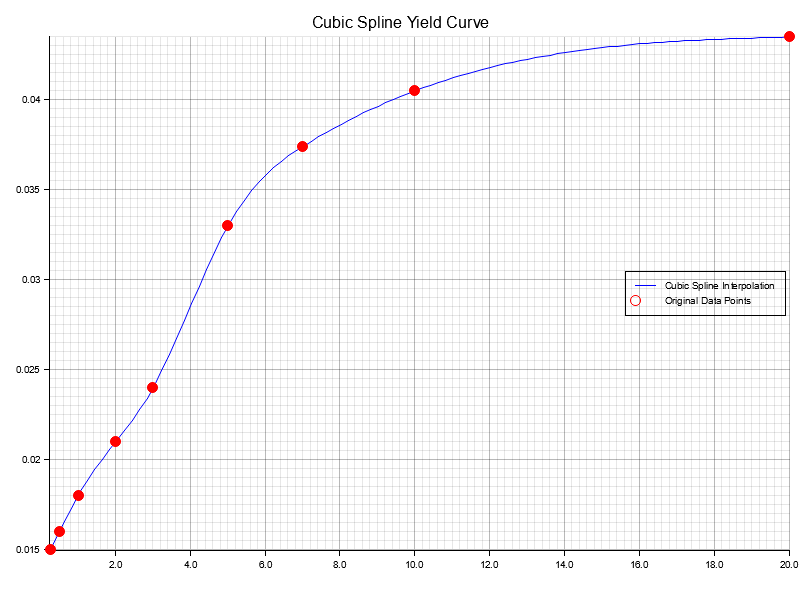

In [177]:
plot_yield_curve(&cs, &x, &y)

We can see that the cubic spline interpolation passes through the existing points, and smoothly curves in the interpolation.

## b)

In [179]:
cs.interpolated_rate(4.0)

0.0284960517181817

# Problem 3

In [180]:
use argmin::{
    core::{CostFunction, Executor},
    solver::neldermead::NelderMead,
};

use itertools::izip;

use plotters::prelude::*;

use polars::prelude::*;

Initialize data.

In [181]:
let df = df!(
    "time to next payment" => [0.4356, 0.2644, 0.2658, 0.4342, 0.0192, 0.4753, 0.3534, 0.1000, 0.2685, 0.4342,
                               0.2274, 0.1027, 0.2712, 0.4370, 0.4822, 0.2260, 0.4822, 0.2260, 0.2301, 0.4808,
                               0.4932, 0.4959, 0.2397, 0.4959, 0.2397, 0.4959, 0.2397, 0.2438, 0.4945],
    "payment frequency" => [0.5; 29],
    "time to maturity" => [0.4356, 0.7644, 1.2658, 1.9342, 2.0192, 2.9753, 3.3534, 3.6000, 4.2685, 4.9342,
                           5.2274, 5.6027, 6.2712, 6.9370, 7.4822, 7.7260, 8.4822, 8.7260, 9.2301, 9.9808,
                           25.4932, 26.4959, 26.7397, 27.4959, 27.7397, 28.4959, 28.7397, 29.2438, 29.9945],
    "coupon rate" => [0.0078, 0.0078, 0.0065, 0.0053, 0.0028, 0.0065, 0.0140, 0.0165, 0.0203, 0.0165,
                      0.0440, 0.0228, 0.0265, 0.0228, 0.0340, 0.0378, 0.0265, 0.0303, 0.0328, 0.0253,
                      0.0440, 0.0465, 0.0490, 0.0428, 0.0440, 0.0340, 0.0415, 0.0428, 0.0378],
    "clean price" => [100.30, 100.48, 100.50, 100.31, 99.78, 100.16, 102.34, 103.08, 104.19, 102.06,
                      115.91, 104.36, 105.86, 102.97, 110.53, 113.09, 103.98, 106.50, 108.00, 101.19,
                      117.58, 122.28, 126.97, 115.19, 117.47, 98.98, 112.44, 114.67, 105.75]
)?;

LaTeXDataFrame(df.clone())

We'll have some initial constants for when we begin to optimize our Nelson-Siegel model.

In [182]:
const INIT_BETA_0: f64 = 0.03;
const INIT_BETA_1: f64 = -0.02;
const INIT_BETA_2: f64 = 0.02;
const INIT_LAMBDA: f64 = 1.0;
const P: f64 = 100.0;

Before we run Nelson-Siegel, we need to add some extra columns that we will need for our calculations.

In [ ]:
let coupon_payment =
    (col("coupon rate") * col("payment frequency") * lit(P)).alias("coupon payment");

let dirty_price = (col("clean price")
    + col("coupon payment") * (col("payment frequency") - col("time to next payment"))
        / col("payment frequency"))
.alias("dirty price");

let num_remaining_payments = (((col("time to maturity") / col("payment frequency")).floor()
    + lit(1))
.cast(DataType::Int32))
.alias("num remaining payments");

let weight = lit(1.0).alias("weight");

let df = df.clone().lazy().with_column(coupon_payment).collect()?;

let df = df
    .clone()
    .lazy()
    .with_columns(vec![
        dirty_price.clone(),
        num_remaining_payments.clone(),
        weight.clone(),
    ])
    .collect()?;

LaTeXDataFrame(df.clone())

We'll define the rate function as:
$$ R(0, t) = \beta_0 + \beta_1 \left(\frac{1 - e^{-\lambda t}}{\lambda t}\right) + \beta_2 \left(\frac{1 - e^{-\lambda t}}{\lambda t} - e^{-\lambda t}\right)$$

In [193]:
df.clone().lazy().select([col("num_remaining_payments")]).collect()?

not found: num_remaining_payments



Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["time to next payment", "payment frequency", "time to maturity", "coupon rate"]; PROJECT */9 COLUMNS


In [184]:
fn r(beta_0: f64, beta_1: f64, beta_2: f64, lambda: f64, t: f64) -> f64 {
    beta_0
        + beta_1 * ((1.0 - (-lambda * t).exp()) / (lambda * t))
        + beta_2 * ((1.0 - (-lambda * t).exp()) / (lambda * t) - (-lambda * t).exp())
}

And store the dataframe of bond information in a struct, so we can implement optimization on it.

In [185]:
#[derive(Clone, Default)]

struct NelsonSiegel {
    df: DataFrame,
}

In our optimizer, we need to calculate the theoretical price using our rate function and discounting each payoff.

$$\hat{B} = \sum_{i=1}^m \left[e^{-r(0, t_i) \cdot t_i} \cdot c\right] + e^{-r(0, t_m) \cdot t_m} \cdot P$$

We want to find $\beta_0$, $\beta_1$, $\beta_2$, and $\lambda$ that minimizes

$$\sum_{i=1}^N w_i (\hat{B_i} - B_i)^2$$

In [194]:
impl CostFunction for NelsonSiegel {
    type Param = Vec<f64>;

    type Output = f64;

    fn cost(&self, param: &Self::Param) -> Result<Self::Output, argmin_math::Error> {
        let beta_0 = param[0];

        let beta_1 = param[1];

        let beta_2 = param[2];

        let lambda = param[3];

        let lf = self.df.clone().lazy().with_column(
            map_multiple(
                move |cols| match cols {
                    [a, b, c, d, e] => {
                        let (a, b, c, d, e) =
                            (a.clone(), b.clone(), c.clone(), d.clone(), e.clone());
                        println!("ISSUES");
                        let num_remaining_payments = a.i32()?;

                        let time_to_next_payment = b.f64()?;

                        let time_to_maturity = c.f64()?;

                        let coupon_payment = d.f64()?;

                        let payment_frequency = e.f64()?;

                        let res: Float64Chunked = izip!(
                            num_remaining_payments,
                            time_to_next_payment,
                            time_to_maturity,
                            coupon_payment,
                            payment_frequency
                        )
                        // calculate theoretical price
                        .map(|(m, t1, tm, c, dt)| match (m, t1, tm, c, dt) {
                            // coupon payments
                            (Some(m), Some(t1), Some(tm), Some(c), Some(dt)) => Some(
                                (1..=m).map(|i| {
                                    let t = t1 + (i as f64 - 1.0) * dt;
                                    (-r(beta_0, beta_1, beta_2, lambda, t) * t).exp() * c
                                })
                                .sum::<f64>()

                                // add principal
                                + (-r(beta_0, beta_1, beta_2, lambda, tm) * tm).exp()
                                    * P,
                            ),

                            _ => None,
                        })
                        .collect();

                        Ok(Some(res.into_column()))
                    }

                    _ => Err(PolarsError::ComputeError(
                        "Expected exactly 5 columns".into(),
                    )),
                },
                &[
                    col("num remaining payments"),
                    col("time to next payment"),
                    col("time to maturity"),
                    col("coupon payment"),
                    col("payment frequency"),
                ],
                GetOutput::from_type(DataType::Float64),
            )
            .alias("theoretical price"),
        );

        let cost_expr =
            (col("dirty price") - col("theoretical price")).pow(2.0) * col("weight");

        let cost_df = lf.select([cost_expr.sum().alias("cost")]).collect()?;

        let cost: f64 = cost_df.column("cost")?.f64()?.get(0).unwrap();

        Ok(cost)
    }
}

Error: conflicting implementations of trait `CostFunction` for type `NelsonSiegel`

Error: type annotations needed

Error: type annotations needed

We'll be using Nelder-Mead for optimization, because it only requires a cost function. We will begin by constructing our simplex for it, then creating the solver, then executing it.

In [195]:
let nelson_siegel = NelsonSiegel { df: df.clone() };

let initial_params = vec![INIT_BETA_0, INIT_BETA_1, INIT_BETA_2, INIT_LAMBDA];

let perturbation = 0.1;

let mut simplex = vec![initial_params.clone()];

for i in 0..initial_params.len() {
    let mut new_vertex = initial_params.clone();

    new_vertex[i] += perturbation;

    simplex.push(new_vertex);
}

let solver: NelderMead<Vec<f64>, f64> = NelderMead::new(simplex).with_sd_tolerance(1e-10)?;

let res = Executor::new(nelson_siegel, solver).run().unwrap();

let state = res.state().param.clone().unwrap();

let beta_0 = state[0];

let beta_1 = state[1];

let beta_2 = state[2];

let lambda = state[3];

(beta_0, beta_1, beta_2, lambda)

thread '<unnamed>' panicked at C:\Users\shaason\.cargo\registry\src\index.crates.io-6f17d22bba15001f\argmin-0.10.0\src\solver\neldermead\mod.rs:334:53:
called `Result::unwrap()` on an `Err` value: not found: num_remaining_payments

Resolved plan until failure:

	---> FAILED HERE RESOLVING 'select' <---
DF ["time to next payment", "payment frequency", "time to maturity", "coupon rate"]; PROJECT */9 COLUMNS

Stack backtrace:
   0: std::backtrace_rs::backtrace::dbghelp64::trace
             at /rustc/e71f9a9a98b0faf423844bf0ba7438f29dc27d58\library/std\src\..\..\backtrace\src\backtrace\dbghelp64.rs:91
   1: std::backtrace_rs::backtrace::trace_unsynchronized
             at /rustc/e71f9a9a98b0faf423844bf0ba7438f29dc27d58\library/std\src\..\..\backtrace\src\backtrace\mod.rs:66
   2: std::backtrace::Backtrace::create
             at /rustc/e71f9a9a98b0faf423844bf0ba7438f29dc27d58\library/std\src\backtrace.rs:331
   3: std::backtrace::Backtrace::capture
             at /rustc/e71f9a9a98b0faf4

Now we will plot the yield curve generated by the Nelson-Siegel model.

In [178]:
let t_values: Vec<f64> = (5..=300).map(|x| x as f64 / 10.0).collect();

let yield_values: Vec<f64> = t_values
    .iter()
    .map(|&t| r(beta_0, beta_1, beta_2, lambda, t))
    .collect();

my_evcxr_figure((1600, 1200), |root| {
    root.fill(&WHITE).unwrap();

    let mut chart = ChartBuilder::on(&root)
        .caption("Yield Curve (Nelson-Siegel)", ("sans-serif", 25))
        .margin(10)
        .x_label_area_size(40)
        .y_label_area_size(50)
        .build_cartesian_2d(0.0..30.0, -0.0..0.05)
        .unwrap();

    chart.configure_mesh().draw().unwrap();

    // Plot the yield curve

    chart
        .draw_series(LineSeries::new(
            t_values
                .iter()
                .zip(yield_values.iter())
                .map(|(&t, &y)| (t, y)),
            &BLUE,
        ))
        .unwrap()
        .label("Yield")
        .legend(|(x, y)| PathElement::new(vec![(x, y), (x + 20, y)], BLUE));

    // Configure the legend

    chart
        .configure_series_labels()
        .background_style(WHITE)
        .draw()
        .unwrap();

    Ok(())
})

Error: cannot find value `beta_0` in this scope

Error: cannot find value `beta_1` in this scope

Error: cannot find value `beta_2` in this scope

Error: cannot find value `lambda` in this scope